# Code from Logit.ipynb

#### Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from numpy import mean, std
from matplotlib import pyplot

#### Import Data

In [2]:
def get_data():
    url = 'https://raw.githubusercontent.com/COGS118A/Group009-SP23/main/clean_data.csv'
    data = pd.read_csv(url)
    data = data.dropna()
    print(data.shape)
    return data

The provided code performs the following tasks:

1. `get_dataset(data)`: This function takes a `data` input and prepares the dataset for training. It separates the features and the target variable, performs a train-test split with a test size of 0.3 and a random state of 42, and returns the following variables: `X` (features), `y` (target variable), `X_train` (training set features), `X_test` (testing set features), `y_train` (training set target variable), and `y_test` (testing set target variable).

2. `get_models(X_train, X_test, y_train, y_test)`: This function takes the training and testing sets and creates multiple logistic regression models with different hyperparameters. It iterates five times, each time creating a logistic regression model with increasing values for the maximum number of iterations (`max_iter`) and regularization strength (`C`). The models are trained on the `X_train` and `y_train` data, and their predictions are obtained for the `X_test` data. The function returns a dictionary (`models`) where the keys are the model names (e.g., 'Logistic Regression 1', 'Logistic Regression 2', etc.) and the values are dictionaries containing the respective model and its predictions.

3. `get_SV(models, X_train, X_test, y_train, y_test)`: This function takes the models generated in the previous step along with the training and testing sets and creates a soft voting classifier. It extracts the individual models and their names from the `models` dictionary and uses them as estimators for the voting classifier. The voting classifier is then trained on the `X_train` and `y_train` data, and its predictions are obtained for the `X_test` data. The function adds the voting classifier to the `models` dictionary with the key 'Soft Voting' and returns the updated dictionary.

4. `get_accuracy(model, X, y)`: This function calculates the accuracy scores of a given model using cross-validation. It uses a repeated stratified k-fold cross-validation with 10 splits and 3 repeats. The function returns an array of accuracy scores for each fold.

The main part of the code then executes the following steps:

1. Calls `get_dataset(get_data())` to obtain the dataset and assign the returned values to variables `X`, `y`, `X_train`, `X_test`, `y_train`, and `y_test`.

2. Calls `get_models(X_train, X_test, y_train, y_test)` to generate multiple logistic regression models and store them in the `models` dictionary.

3. Calls `get_SV(models, X_train, X_test, y_train, y_test)` to add a soft voting classifier to the `models` dictionary.

4. Initializes empty lists `results` and `names`.

5. Iterates over the items in the `models` dictionary and for each model, performs cross-validation using `get_accuracy(model, X, y)`. The accuracy scores are appended to the `results` list, and the model names are appended to the `names` list. Additionally, the mean and standard deviation of the accuracy scores are printed for each model.

6. Uses `pyplot` to create a boxplot of the accuracy scores (`results`) for each model (`names`). The boxplot is displayed using `pyplot.show()`.

In [3]:
def get_dataset(data):
    X = data.drop('good_outcome', axis=1)
    y = data['good_outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X, y, X_train, X_test, y_train, y_test

def get_models(X_train, X_test, y_train, y_test):
    models = {}

    for i in range(5):
        model_name = f'Logistic Regression {i+1}'  # Generate a unique model name

        model = LogisticRegression(max_iter=(i+1)*1000, C=(i+1)*0.1)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        models[model_name] = {
            'model': model,
            'predictions': y_pred
        }
    return models

def get_SV(models, X_train, X_test, y_train, y_test):
    individual_models = []

    for model_name, model_info in models.items():
        individual_models.append((model_name, model_info['model']))

    voting_classifier = VotingClassifier(estimators=individual_models, voting='soft')
    voting_classifier.fit(X_train, y_train)

    y_pred_voting = voting_classifier.predict(X_test)

    models['Soft Voting'] = {
        'model': voting_classifier,
        'predictions': y_pred_voting
    }
    return models

def get_accuracy(model, X, y): #cross valid
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [4]:
X, y, X_train, X_test, y_train, y_test = get_dataset(get_data())

models = get_models(X_train, X_test, y_train, y_test)
models = get_SV(models, X_train, X_test, y_train, y_test)

results, names = list(), list()

for name, model_info in models.items():
    model = model_info['model']
    scores = get_accuracy(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

(16467, 215)
>Logistic Regression 1 0.712 (0.028)
>Logistic Regression 2 0.708 (0.026)
>Logistic Regression 3 0.711 (0.029)
>Logistic Regression 4 0.713 (0.029)
>Logistic Regression 5 0.714 (0.027)
>Soft Voting 0.714 (0.027)


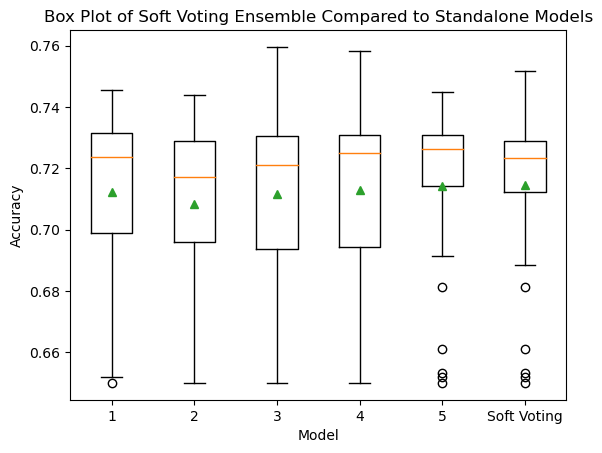

In [5]:
# plot model performance for comparison
plt.boxplot(results, labels=[1, 2, 3, 4, 5, "Soft Voting"], showmeans=True)
plt.title('Box Plot of Soft Voting Ensemble Compared to Standalone Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig('model_performance.jpg')
plt.show()

<Figure size 640x480 with 0 Axes>

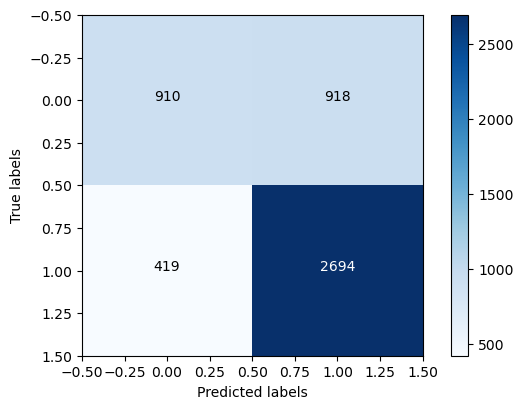

In [6]:
import itertools

cm_logit = confusion_matrix(y_test, models['Soft Voting']['predictions'])

plt.figure()
plt.figure(figsize=(6, 4))
plt.imshow(cm_logit, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

thresh = cm_logit.max() / 2.
for i, j in itertools.product(range(cm_logit.shape[0]), range(cm_logit.shape[1])):
    plt.text(j, i, format(cm_logit[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_logit[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [7]:
# Evaluation Metrics
recall = 1257 / (1257 + 571)
precision = 1257 / (1257 + 185)
print('Recall', recall, '\n')
print('Precision', precision, '\n')
print('F1-Score', 2 * ((recall * precision) / (precision + recall)), '\n')
print('Specificity', 2928 / (2928 + 185), '\n')

Recall 0.687636761487965 

Precision 0.8717059639389736 

F1-Score 0.7688073394495414 

Specificity 0.9405717956954706 



# Using SVM

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from statistics import mean, stdev
import matplotlib.pyplot as plt

def get_models(X_train, X_test, y_train, y_test):
    models = {}
    for i in range(3):
        model_name = f'SVM {i+1}'  # Generate a unique model name
        model = SVC(kernel='linear', C=(i+1)*0.1, probability=True)
        model.fit(X_train, y_train)
        models[model_name] = model
    return models

def get_accuracy(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred)

def plot_boxplot(results, names):
    plt.boxplot(results, labels=names, showmeans=True)
    plt.title('Box Plot of Soft Voting Ensemble Compared to Standalone Models')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.savefig('model_performance_SVM.jpg')
    plt.show()

In [ ]:
X, y, X_train, X_test, y_train, y_test = get_dataset(get_data())

models = get_models(X_train, X_test, y_train, y_test)
voting_classifier = VotingClassifier(estimators=models.items(), voting='soft', n_jobs=-1)
voting_classifier.fit(X_train, y_train)

models['Soft Voting'] = voting_classifier

results, names = [], []

for name, model in models.items():
    scores = get_accuracy(model, X_test, y_test)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), stdev(scores)))

plot_boxplot(results, names)

(16467, 215)


In [ ]:
cm_svm = confusion_matrix(y_test, models['Soft Voting']['predictions'])

plt.figure()
plt.figure(figsize=(6, 4))
plt.imshow(cm_svm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

thresh = cm_svm.max() / 2.
for i, j in itertools.product(range(cm_svm.shape[0]), range(cm_svm.shape[1])):
    plt.text(j, i, format(cm_svm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_svm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()